
 Loan prediction. 
 ---
In this project I will solve a classification problem with XGBOOST model. This is a contest on Analytics Vidhya. The problem statement and data sets can be found in:
https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import stats 
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold
import seaborn as sns
import tensorflow as tf 
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
pd.options.mode.chained_assignment = None 
plt.style.use('ggplot')

In [ ]:
# Read data
train_set = pd.read_csv('train.csv')
train_Y = train_set['Loan_Status']
test_X = pd.read_csv('test.csv')
train_set.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
# Prepare the train and test set
train_set.pop('Loan_ID')
loan_id = test_X.pop('Loan_ID')
print('train_set =', train_set.shape)
print('test_X =', test_X.shape)

train_set = (614, 12)
test_X = (367, 11)




First I do an exploratory data analysis (EDA) on dataset to visualize and analyse the features in order to get an isight about the dataset. 



In [ ]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


  Data includes 6 categorical and 5 numerical features as well as target labels which is Loan status.

 First I do the univariate analysis to understand and visualize the features individually.

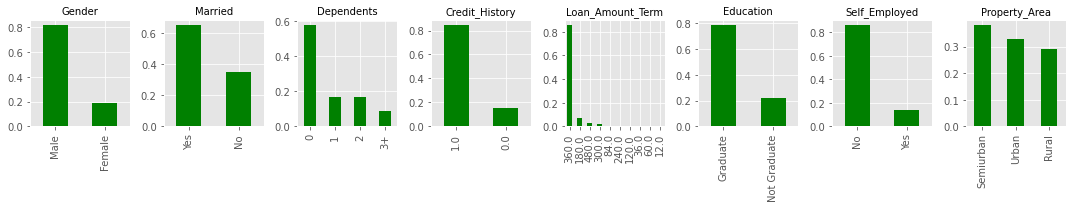

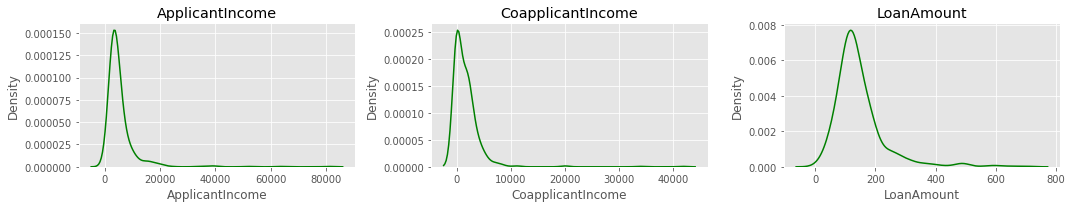

In [ ]:
fig, ax = plt.subplots(1,8, figsize=(15,3))
columns = ["Gender", "Married","Dependents", "Credit_History",
          "Loan_Amount_Term","Education", "Self_Employed", "Property_Area"]
for i, column in enumerate(columns):
  train_set[column].value_counts(normalize=True).plot.bar(ax=ax[i], color='green')
  ax[i].set_title('%s' %column, fontsize=10)  
  plt.tight_layout()

fig, ax = plt.subplots(1,3, figsize=(15,3))
for i, column in enumerate(["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]):
  sns.kdeplot(train_set[column], ax=ax[i], color='green')
  ax[i].set_title('%s' %column)  
  plt.tight_layout()            

We can see from the histograms that the distribution of Applicant Income, Coapplicant Income and Loan Amount is right skewed. Next I will look at their box plots.

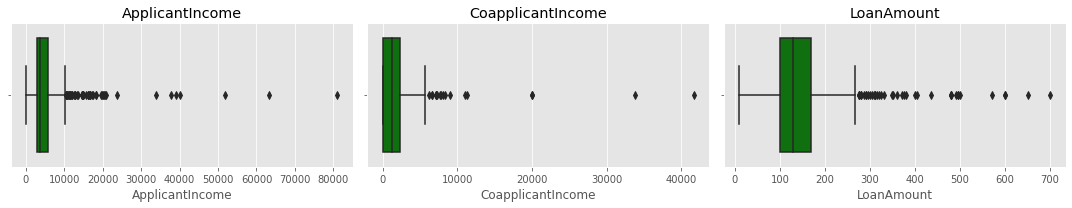

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
for i, column in enumerate(["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]):
  sns.boxplot(x=train_set[column], ax=ax[i], color='green')
  ax[i].set_title('%s' %column)  
  plt.tight_layout()  

From the box plots we can see the presence of outliers in these features. I will deal with the outliers later. Before that I will do the bivariate analysis to see how features are related to the target labels.

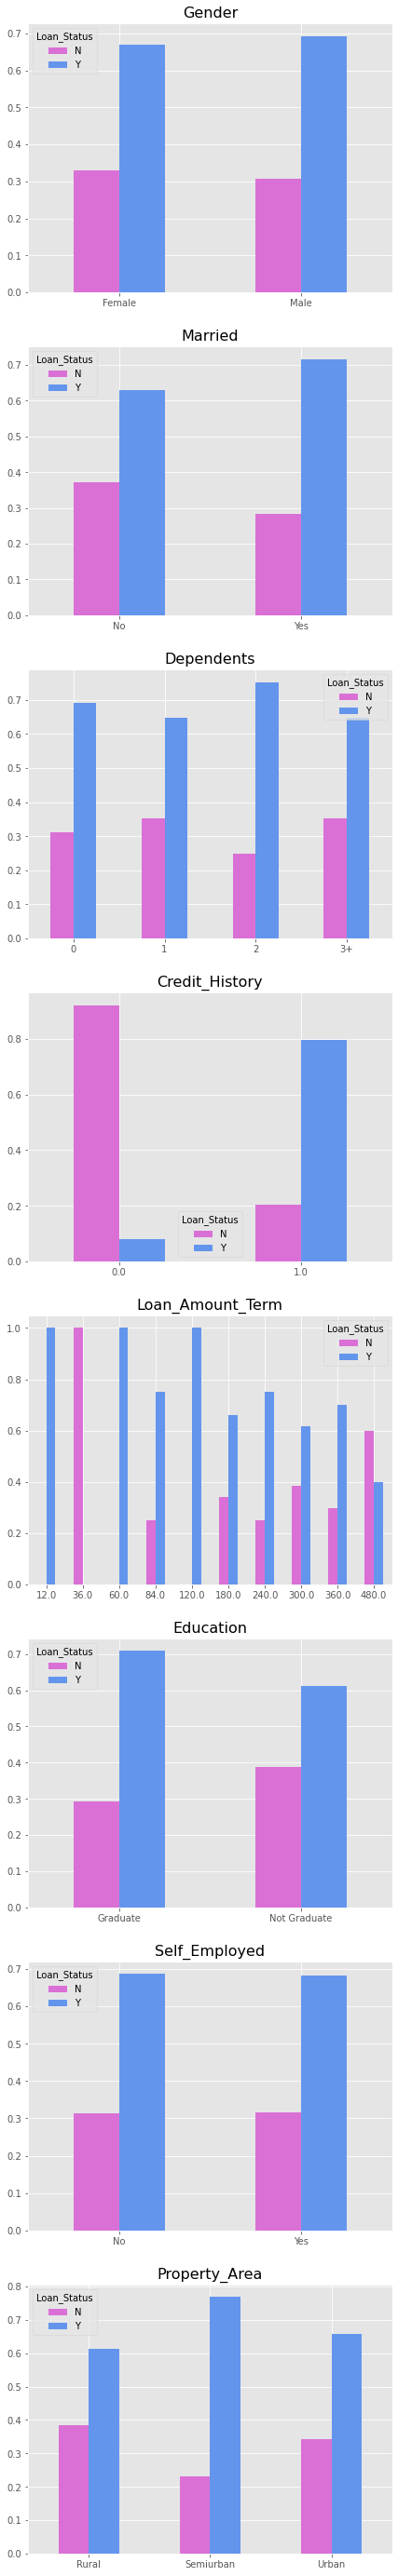

In [ ]:
fig, ax = plt.subplots(8, figsize=(7,50))
columns = ["Gender", "Married","Dependents", "Credit_History",
          "Loan_Amount_Term","Education", "Self_Employed", "Property_Area"]
for i, column in enumerate(columns):
  ct = pd.crosstab(train_set[column], train_Y)
  ct.div(ct.sum(1), axis=0).plot(kind='bar', ax=ax[i], color=['orchid','cornflowerblue'], rot=0)
  ax[i].set_title('%s' %column, fontsize=16)
  ax[i].set_xlabel(None)

Applicants with higher credit history or education are more likely to get approved for a loan. Also married people and people from semiurban area are more likely to get approved. Gender and being self-employed doesn't make a difference much. 

Also we can see from the loan_amount_term bar plot that the requests with 12, 60 and 120 terms are %100 approved and the 36-term requests are always rejected. This is probably because we only have a few of these loan terms (perhaps only one or two for each of these categories) in our dataset and this can be also verified by looking at the bar plot in the univariate analysis. Therefore I remove these categories from loan_amount_term feature in our dataset.



In [ ]:
indexes = train_set[(train_set['Loan_Amount_Term']==12.0)|(train_set['Loan_Amount_Term']==36.0)|
                    (train_set['Loan_Amount_Term']==60.0)|(train_set['Loan_Amount_Term']==120.0)].index
train_set.drop(indexes, inplace=True)
train_set.reset_index(drop=True)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
601,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
602,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
603,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
604,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


Next I will look at the continuous features. For continuous features first I cut the data into different bins and then apply crosstab as before.

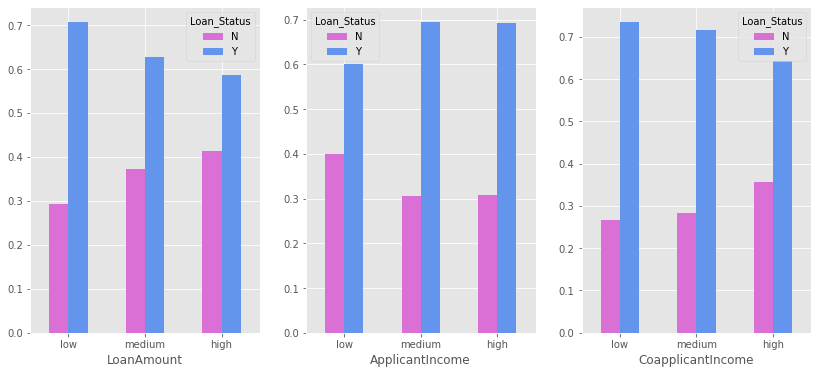

In [ ]:
df = train_set.copy()
fig, ax = plt.subplots(1,3, figsize=(14,6))
loanbins = np.array([0, 2, 3, 8])*100
coapbins = np.array([0, 2, 5, 40])*1000
apbins = np.array([0, 2, 5, 80])*1000
labels = ['low', 'medium', 'high']
colors = ['orchid','cornflowerblue']
df['LoanAmount'] = pd.cut(df['LoanAmount'], bins=loanbins, labels=labels)
df['ApplicantIncome'] = pd.cut(df['ApplicantIncome'], bins=apbins, labels=labels)
df['CoapplicantIncome'] = pd.cut(df['CoapplicantIncome'], bins=coapbins, labels=labels)
loan_ct = pd.crosstab(df ['LoanAmount'] , train_Y)
app_ct = pd.crosstab(df ['ApplicantIncome'] , train_Y)
coap_ct = pd.crosstab(df ['CoapplicantIncome'] , train_Y)
loan_ct.div(loan_ct.sum(1), axis=0).plot(kind="bar", ax=ax[0], color=colors, rot=0)
app_ct.div(app_ct.sum(1), axis=0).plot(kind="bar", ax=ax[1], color=colors, rot=0)
coap_ct.div(coap_ct.sum(1), axis=0).plot(kind="bar", ax=ax[2], color=colors, rot=0)
plt.show()

I expected that applicants with higher coapplicant incomes are more likely to get approved for a loan than applicants with medium or low coapplicant income, but the last plot shows the opposite. Now let's see what happens if I lower the maximum bin edge in coapplicant income from 40,000 to 10,000.


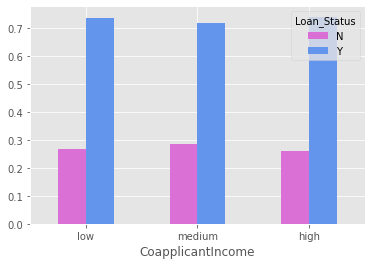

In [ ]:
df = train_set.copy()
coapbins = np.array([0, 2, 5, 10])*1000
labels = ['low', 'medium', 'high']
colors = ['orchid','cornflowerblue']
df['CoapplicantIncome'] = pd.cut(df['CoapplicantIncome'], bins=coapbins, labels=labels)
coap_ct = pd.crosstab(df ['CoapplicantIncome'] , train_Y)
coap_ct.div(coap_ct.sum(1), axis=0).plot(kind="bar", color=colors, rot=0)
plt.show()

Now it makes more sense. Therefore we can conclude that there are actually outliers in this feature. These ouliers can be removed using IQR method. 
I will chose proper quartiles so that the range of this features becomes close to $(0, 10000)$ as I discussed before.



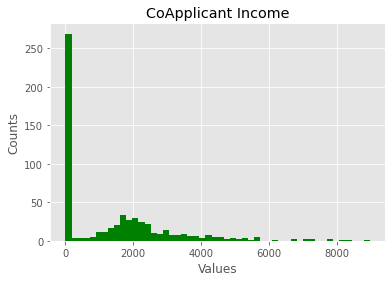

In [ ]:
# IQR method
th1, th2 = np.percentile(train_set["CoapplicantIncome"],[0,92])
iqr = th2 - th1
lower_bound = th1 -(1.5 * iqr) 
upper_bound = th2 +(1.5 * iqr)
indexes= train_set[(train_set["CoapplicantIncome"] > upper_bound)
                   | (train_set["CoapplicantIncome"] < lower_bound)].index
train_set.drop(indexes, inplace=True)
train_set = train_set.reset_index(drop=True)
#for index in sorted(indexes, reverse=True):
  #del train_Y[index]
plt.figure(1)
train_set['CoapplicantIncome'].hist(bins=50, color='green')
plt.title('CoApplicant Income')
plt.xlabel('Values')
plt.ylabel('Counts')
plt.show()

Another way to deal with outliers in our data is to use log transformation. The reason is that the features on the box plots are right skewed and Log has this property that it doesn't affect smaller values much but it reduces large values. Therefore after applying log transformation we expect to see histograms become more similar to normal distribution or more symmetric and this reduces the effect of big outliers.

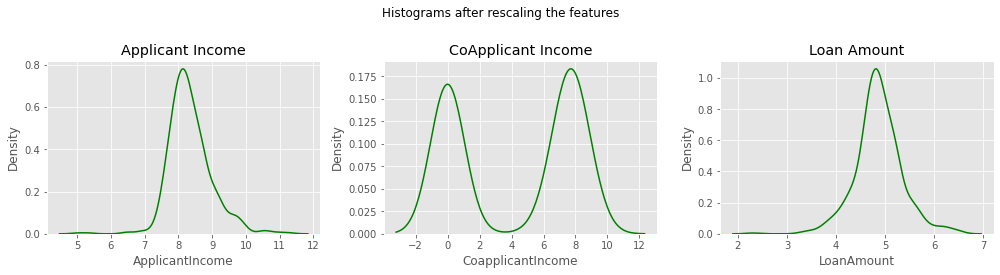

In [ ]:
#  We can apply log transformation to the right skewed data
train_set['CoapplicantIncome'] = train_set['CoapplicantIncome'].apply(lambda x: np.log(1+x))
train_set['LoanAmount'] = train_set['LoanAmount'].apply(lambda x: np.log(1+x))
train_set['ApplicantIncome'] = train_set['ApplicantIncome'].apply(lambda x: np.log(1+x))
 
test_X['CoapplicantIncome'] = test_X['CoapplicantIncome'].apply(lambda x: np.log(1+x))
test_X['LoanAmount'] = test_X['LoanAmount'].apply(lambda x: np.log(1+x))
test_X['ApplicantIncome'] = test_X['ApplicantIncome'].apply(lambda x: np.log(1+x))

plt.figure(figsize=(14,9))
plt.subplot(331)
sns.kdeplot(train_set['ApplicantIncome'], color='green')
plt.title('Applicant Income')
plt.tight_layout()
plt.subplot(332)
sns.kdeplot(train_set['CoapplicantIncome'], color='green')
plt.title('CoApplicant Income')
plt.subplot(333)
sns.kdeplot(train_set['LoanAmount'], color='green')
plt.title('Loan Amount')
plt.tight_layout()
plt.suptitle('Histograms after rescaling the features', fontsize=12, y=1.04)
plt.show()

We can see that after the log transformation the distribution of Applicant Income and Loan Amount is fairly normal. Moreover the log transformation has removed the skewness of these features.

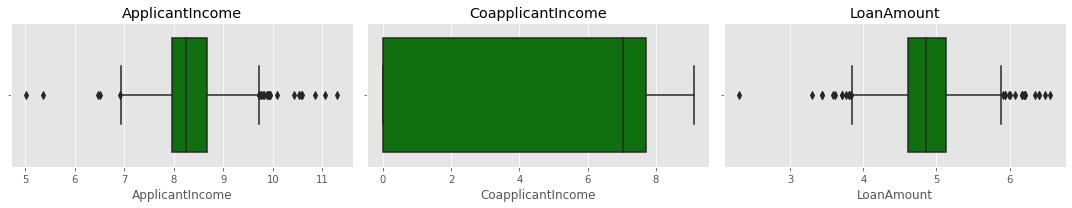

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
for i, column in enumerate(["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]):
  sns.boxplot(x=train_set[column], ax=ax[i], color='green')
  ax[i].set_title('%s' %column)  
  plt.tight_layout() 

From the box plots we can see that log transformation has reduced the amount of outliers (compare with previous box plots.)

Next I will do the multivariate analysis to see how the features are correlated with each other. Since data includes object type categorical values, I use pd.factorize() to convert them to numerical values first and then apply the Pearson correlation to them.

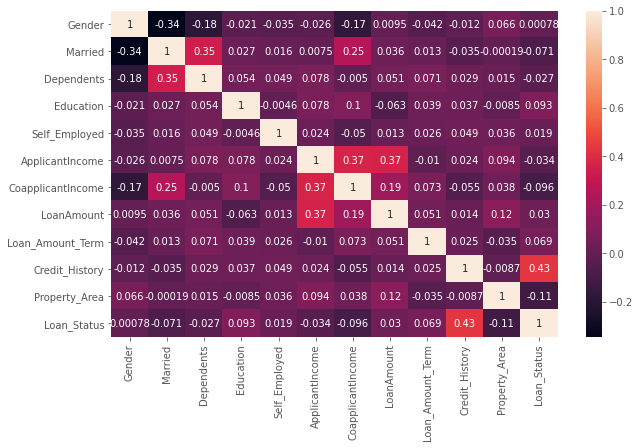

In [ ]:
corr = train_set.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson')
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap=None)
plt.show()

From the heatmap we can see Gender, Married and Dependents are highly correlated to each other. Moreover Applicant income, CoapplicanIncome and LoanAmount are highly correlated.

We can also see Gender is almost uncorrelated to target variables, Loan_Status, and so it doesn't count toward the learning. Therefore we can remove this feature from dataset to lower the computational costs.

In [ ]:
train_set.drop(['Gender'], axis=1, inplace=True)
test_X.drop(['Gender'], axis=1, inplace=True)

In next step I will convert object type values to numerical values. 

I use the bivariate analysis and look at the bar plots to complete this task. For Self_Employed, since different categories had the same chance for loan approval (there is no order) I will encode them with one-hot encoding.

For Married and Education features since different categories have different chance of approval I will use oridinal encoding because it seems that we actually have an ordinal relationship here: Married > Not Married and Graduate > Not Graduate. 

I will apply these ideas to all features.

In [ ]:
train_Y = train_set.pop('Loan_Status')
train_Y = pd.DataFrame(train_Y, columns=['Loan_Status'])

In [ ]:
# Convert all values to numeric values

# One-hot encoding
train_set = pd.get_dummies(train_set, columns=["Self_Employed"],
                         drop_first=False)
test_X = pd.get_dummies(test_X, columns=["Self_Employed"],
                        drop_first=False)

# # Frequency encoding
# encoded_names = ['g', 'm', 'e','s', 'p']
# columns = ["Gender","Married","Education","Self_Employed", "Property_Area"]
# for (n, column) in zip(encoded_names, columns):
#    n = train_X.groupby(column).size()/len(train_X)
#    train_X[column] = train_X[column].map(n)
#    valid_X[column] = valid_X[column].map(n)
#    test_X[column] = test_X[column].map(n)

# Ordinal encoding
train_set['Dependents'] = [0.0 if x=='1' else 1.0 if x=='3+' else 2.0 if x=='0'
                     else 3.0 if x=='2' else np.NaN for x in train_set['Dependents']]    
test_X['Dependents'] = [0.0 if x=='1' else 1.0 if x=='3+' else 2.0 if x=='0'
                     else 3.0 if x=='2' else np.NaN for x in test_X['Dependents']] 
train_set['Married'] = [1.0 if x=='Yes' else 0.0 if x=='No' else np.NaN
                        for x in train_set['Married']]                     
test_X['Married'] = [1.0 if x=='Yes' else 0.0 if x=='No' else np.NaN
                     for x in test_X['Married']]  
train_set['Education'] = [1.0 if x=='Graduate' else 0.0 if x=='Not Graduate' else np.NaN
                          for x in train_set['Education']]                     
test_X['Education'] = [1.0 if x=='Graduate' else 0.0 if x=='Not Graduate' else np.NaN
                       for x in test_X['Education']]                                          
train_set['Property_Area'] = [0.0 if x=='Rural' else 1.0 if x=='Urban' else 2.0 if x=='Semiurban'
                              else np.NaN for x in train_set['Property_Area']]                     
test_X['Property_Area'] = [0.0 if x=='Rural' else 1.0 if x=='Urban' else 2.0 if x=='Semiurban'
                          else np.NaN for x in test_X['Property_Area']]                     

train_Y['Loan_Status'] = [1.0 if x=='Y' else 0.0 for x in train_Y['Loan_Status']]



Model:
---

 I have used K-Fold stratified cross validation to split the dataset. At each step of K-Fold CV, I have imputed, and normalized the training set and have applied the same transformation to the validation set and test set to avoid data leakage.

In [ ]:
pd.concat([train_set, test_X]).isnull().sum()

Married               3
Dependents           25
Education             0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           27
Loan_Amount_Term     20
Credit_History       77
Property_Area         0
Self_Employed_No      0
Self_Employed_Yes     0
dtype: int64

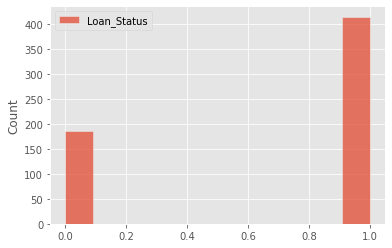

In [ ]:
sns.histplot(train_Y)
plt.show()

XGBOOST:
---
 I have used XGBoost for training. It is a highly efficient decision-tree based model, widely used in data science competitions.
This model is presented by Tianqi Chen and Carlos Guestrin in paper:

" XGBoost: A Scalable Tree Boosting System ".
 

In [ ]:
from xgboost import XGBClassifier

# Data imputation
def imputer(train_X, valid_X, test_X):
  for column in ["Married","Dependents","Credit_History", "Loan_Amount_Term"]:
    train_X[column].fillna(train_X[column].mode()[0], inplace=True)
    valid_X[column].fillna(train_X[column].mode()[0], inplace=True)
    test_X[column].fillna(train_X[column].mode()[0], inplace=True)

  train_X['LoanAmount'].fillna(train_X['LoanAmount'].median(), inplace=True)
  valid_X['LoanAmount'].fillna(train_X['LoanAmount'].median(), inplace=True)
  test_X['LoanAmount'].fillna(train_X['LoanAmount'].median(), inplace=True)
  return [train_X, valid_X, test_X]


# Feature selection
def feature_selector(train_X, train_Y, valid_X, test_X, k):
  selected_features = SelectKBest(score_func=chi2, k=k)
  train_X = selected_features.fit_transform(train_X, train_Y)
  valid_X = selected_features.transform(valid_X)
  test_X = selected_features.transform(test_X)
  return [train_X, valid_X, test_X]


# Feature scaling
def feature_scaler(train_X, valid_X, test_X):
  scaler = MinMaxScaler()
  train_X = scaler.fit_transform(train_X)
  valid_X = scaler.transform(valid_X)
  test_X = scaler.transform(test_X)
  return [train_X, valid_X, test_X]

kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
iter = 0
for train_index, valid_index in kf.split(train_set, train_Y):
  Xtrain, Ytrain = train_set.loc[train_index], train_Y.loc[train_index]
  Xvalid, Yvalid = train_set.loc[valid_index], train_Y.loc[valid_index]
  Xtest = test_X.copy()
  [Xtrain, Xvalid, Xtest ] = imputer(Xtrain, Xvalid, Xtest)
  [Xtrain, Xvalid, Xtest ] = feature_selector(Xtrain, Ytrain, Xvalid, Xtest, 11)
  [Xtrain, Xvalid, Xtest ] = feature_scaler(Xtrain, Xvalid, Xtest)
  model = XGBClassifier(n_estimators=100, max_depth=5)
  model.fit(Xtrain, Ytrain.values.ravel())
  valid_pred = model.predict(Xvalid)
  score = accuracy_score(valid_pred, Yvalid)
  print('accuracy on validation set for fold_{}'.format(iter+1), score)

  # Predict on the test set and save the file
  predictions = model.predict(Xtest)
  pred = ['Y' if x >= 0.5 else 'N' for x in predictions]
  pred_dic = list(zip(loan_id, pred))
  pred_df = pd.DataFrame(pred_dic, columns=['Loan_ID', 'Loan_Status'])
  pred_df.to_csv ('XGBpredict_{}.csv'.format(iter), index = False, header=True)
  
  iter += 1

accuracy on validation set for fold_1 0.775
accuracy on validation set for fold_2 0.7416666666666667
accuracy on validation set for fold_3 0.725
accuracy on validation set for fold_4 0.7916666666666666
accuracy on validation set for fold_5 0.7833333333333333


After submitting the predictions I acheived score %79.2 which is slightly higher than the previous score obtained by DNN.

Finally I will do an experiment on different parameters of XGB and see if I can improve the results.

In [ ]:
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
iter = 0
for train_index, valid_index in kf.split(train_set, train_Y):
  Xtrain, Ytrain = train_set.loc[train_index], train_Y.loc[train_index]
  Xvalid, Yvalid = train_set.loc[valid_index], train_Y.loc[valid_index]
  Xtest = test_X.copy()
  [Xtrain, Xvalid, Xtest ] = imputer(Xtrain, Xvalid, Xtest)
  [Xtrain, Xvalid, Xtest ] = feature_selector(Xtrain, Ytrain, Xvalid, Xtest, 11)
  [Xtrain, Xvalid, Xtest ] = feature_scaler(Xtrain, Xvalid, Xtest)
  for n in [50, 100]:
    for d in [3, 4, 5]:
      model = XGBClassifier(n_estimators=n, max_depth=d)
      model.fit(Xtrain, Ytrain.values.ravel())
      valid_pred = model.predict(Xvalid)
      score = accuracy_score(valid_pred, Yvalid)
      print('accuracy on validation set for [fold, n_estimators, max_depth]={} is'
            .format([iter+1, n, d]), score)

      # Predict on test set and save the file
      predictions = model.predict(Xtest)
      pred = ['Y' if x >= 0.5 else 'N' for x in predictions]
      pred_dic = list(zip(loan_id, pred))
      pred_df = pd.DataFrame(pred_dic, columns=['Loan_ID', 'Loan_Status'])
      pred_df.to_csv ('XGBpredict{}.csv'.
                      format([iter+1, n, d]), index = False, header=True)

  iter += 1

accuracy on validation set for [fold, n_estimators, max_depth]=[1, 50, 3] is 0.8333333333333334
accuracy on validation set for [fold, n_estimators, max_depth]=[1, 50, 4] is 0.825
accuracy on validation set for [fold, n_estimators, max_depth]=[1, 50, 5] is 0.825
accuracy on validation set for [fold, n_estimators, max_depth]=[1, 100, 3] is 0.85
accuracy on validation set for [fold, n_estimators, max_depth]=[1, 100, 4] is 0.8166666666666667
accuracy on validation set for [fold, n_estimators, max_depth]=[1, 100, 5] is 0.775
accuracy on validation set for [fold, n_estimators, max_depth]=[2, 50, 3] is 0.7916666666666666
accuracy on validation set for [fold, n_estimators, max_depth]=[2, 50, 4] is 0.7833333333333333
accuracy on validation set for [fold, n_estimators, max_depth]=[2, 50, 5] is 0.7416666666666667
accuracy on validation set for [fold, n_estimators, max_depth]=[2, 100, 3] is 0.7583333333333333
accuracy on validation set for [fold, n_estimators, max_depth]=[2, 100, 4] is 0.733333333

After submission the predictions the best score achieved with this experiment was 80%
obtaiend by 2 flods, 50 number of estimators and 4 max_depth, which puts me in top 5% among nearly 8800 submissions.